In [9]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime
from scorecardpy import woebin, woebin_ply, woebin_plot, iv
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Google Sheet ID from your URL
sheet_id = "1ZxsqdQ8NlfZ5etCP9LR1vXNWkIcS6mgcnbc_8L-x-pA"

# Create the export URL (CSV format)
# For the first sheet (default)
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"

# Read directly into pandas DataFrame
project_data = pd.read_csv(url)

# Display the first 5 rows
print(project_data)

   LP data_akceptacji  grupa_ryzyka  kod_partnera typ_umowy  scoring_FICO  \
0   1       17/4/2005             2             2         R           702   
1   2       17/4/2005             2             2         N           719   
2   3       17/4/2005             1             3         N           802   
3   4       17/4/2005             1             1         R           723   
4   5       17/4/2005             3             1         U           690   
5   6       21/4/2005             1             3         N           681   
6   7       17/4/2005             1             1         U           805   
7   8       17/4/2005             2             2         R           726   
8   9       17/4/2005             1             1         N           765   
9  10       17/4/2005             3             2         N           693   

   okres_kredytu kwota_kredytu oproc_refin oproc_konkur koszt_pieniadza  \
0             48       $26,500       3.99%        4.99%           1.10%   
1 

In [4]:
# Zakładamy, że project_data jest już wczytany

# Konwersja wartości tekstowych na numeryczne
# Kwota kredytu - usunięcie $ i przecinków
project_data['kwota_kredytu_num'] = project_data['kwota_kredytu'].str.replace('$', '').str.replace(',', '').astype(float)

# Konwersja oprocentowań - usunięcie symbolu %
for col in ['oproc_refin', 'oproc_konkur', 'koszt_pieniadza', 'oproc_propon']:
    project_data[f'{col}_num'] = project_data[col].str.replace('%', '').astype(float)

# Obliczenie percentyli dla kwoty kredytu
p75_kwota = project_data['kwota_kredytu_num'].quantile(0.75)
p90_kwota = project_data['kwota_kredytu_num'].quantile(0.90)

# 1. roznica_oproc - Różnica między oprocentowaniem proponowanym a konkurencyjnym
project_data['roznica_oproc'] = project_data['oproc_propon_num'] - project_data['oproc_konkur_num']

# 2. umowa_N_roznica_oproc - Interakcja między typem umowy N a różnicą oprocentowania
project_data['umowa_N'] = (project_data['typ_umowy'] == 'N').astype(int)
project_data['umowa_N_roznica_oproc'] = project_data['umowa_N'] * project_data['roznica_oproc']

# 3. bardzo_wysoka_kwota - Zmienna binarna oznaczająca, czy kwota kredytu znajduje się powyżej 90 percentyla
project_data['bardzo_wysoka_kwota'] = (project_data['kwota_kredytu_num'] > p90_kwota).astype(int)

# 4. wysoka_kwota - Zmienna binarna oznaczająca, czy kwota kredytu znajduje się powyżej 75 percentyla
project_data['wysoka_kwota'] = (project_data['kwota_kredytu_num'] > p75_kwota).astype(int)

# 5. roznica_kosztu - Różnica w całkowitym koszcie kredytu między ofertą proponowaną a konkurencyjną
project_data['koszt_propon'] = project_data['kwota_kredytu_num'] * (project_data['oproc_propon_num'] / 100) * (project_data['okres_kredytu'] / 12)
project_data['koszt_konkur'] = project_data['kwota_kredytu_num'] * (project_data['oproc_konkur_num'] / 100) * (project_data['okres_kredytu'] / 12)
project_data['roznica_kosztu'] = project_data['koszt_propon'] - project_data['koszt_konkur']

# 6. stosunek_refin_konkur - Stosunek oprocentowania refinansowego do oprocentowania konkurencyjnego
# Unikamy dzielenia przez 0, zastępując zera bardzo małą wartością
project_data['stosunek_refin_konkur'] = project_data['oproc_refin_num'] / project_data['oproc_konkur_num'].replace(0, 0.0001)

# 7. wartosc_refinansowania - Wartość refinansowania obliczona jako (oproc_refin/100) * kwota_kredytu
project_data['wartosc_refinansowania'] = (project_data['oproc_refin_num'] / 100) * project_data['kwota_kredytu_num']

# 8. stopien_refinansowania - Zmienna binarna wskazująca, czy kredyt zawiera komponent refinansowania
project_data['stopien_refinansowania'] = (project_data['oproc_refin_num'] > 0).astype(int)

# 9. ryzyko_vs_oproc - Iloczyn grupy ryzyka i różnicy oprocentowania
project_data['ryzyko_vs_oproc'] = project_data['grupa_ryzyka'] * project_data['roznica_oproc']

# 10. fico_vs_oproc - Iloczyn scoringu FICO i różnicy oprocentowania
project_data['fico_vs_oproc'] = project_data['scoring_FICO'] * project_data['roznica_oproc']

# 11. kwota_na_miesiac - Stosunek kwoty kredytu do liczby miesięcy
project_data['kwota_na_miesiac'] = project_data['kwota_kredytu_num'] / project_data['okres_kredytu']

# Obsługa przypadków NaN i Inf (jeśli wystąpią)
project_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Uzupełnienie wartości NaN medianą dla danej kolumny
for col in ['roznica_oproc', 'umowa_N_roznica_oproc', 'roznica_kosztu', 'stosunek_refin_konkur', 
            'wartosc_refinansowania', 'ryzyko_vs_oproc', 'fico_vs_oproc', 'kwota_na_miesiac']:
    if project_data[col].isna().any():
        median_value = project_data[col].median()
        project_data[col] = project_data[col].fillna(median_value)

# Lista nowych zmiennych
new_variables = [
    'umowa_N_roznica_oproc',
    'bardzo_wysoka_kwota',
    'wysoka_kwota', 
    'roznica_kosztu',
    'stosunek_refin_konkur',
    'wartosc_refinansowania',
    'stopien_refinansowania',
    'ryzyko_vs_oproc',
    'fico_vs_oproc',
    'roznica_oproc',
    'kwota_na_miesiac'
]

print(f"Dodano {len(new_variables)} nowych zmiennych do dataframe project_data:")
for var in new_variables:
    print(f" - {var}")

Dodano 11 nowych zmiennych do dataframe project_data:
 - umowa_N_roznica_oproc
 - bardzo_wysoka_kwota
 - wysoka_kwota
 - roznica_kosztu
 - stosunek_refin_konkur
 - wartosc_refinansowania
 - stopien_refinansowania
 - ryzyko_vs_oproc
 - fico_vs_oproc
 - roznica_oproc
 - kwota_na_miesiac


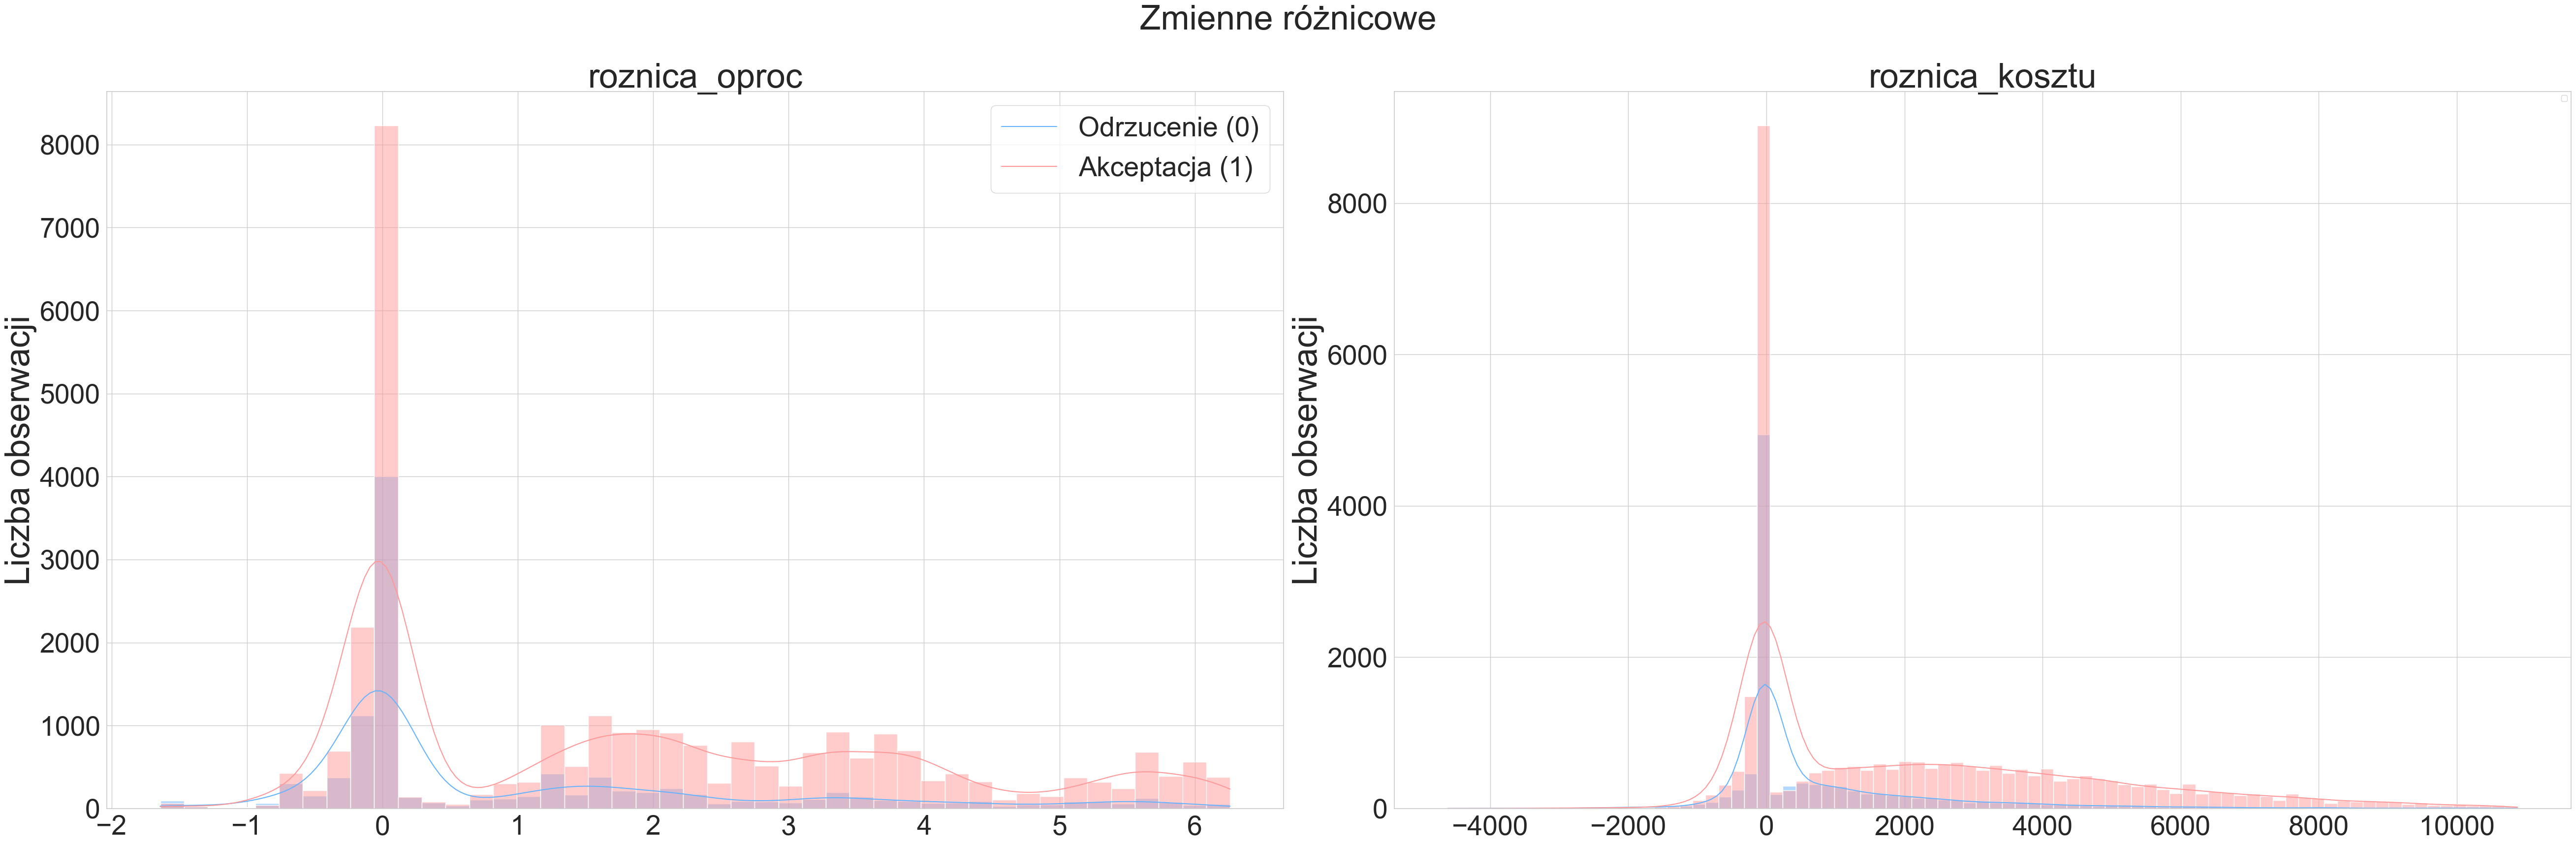

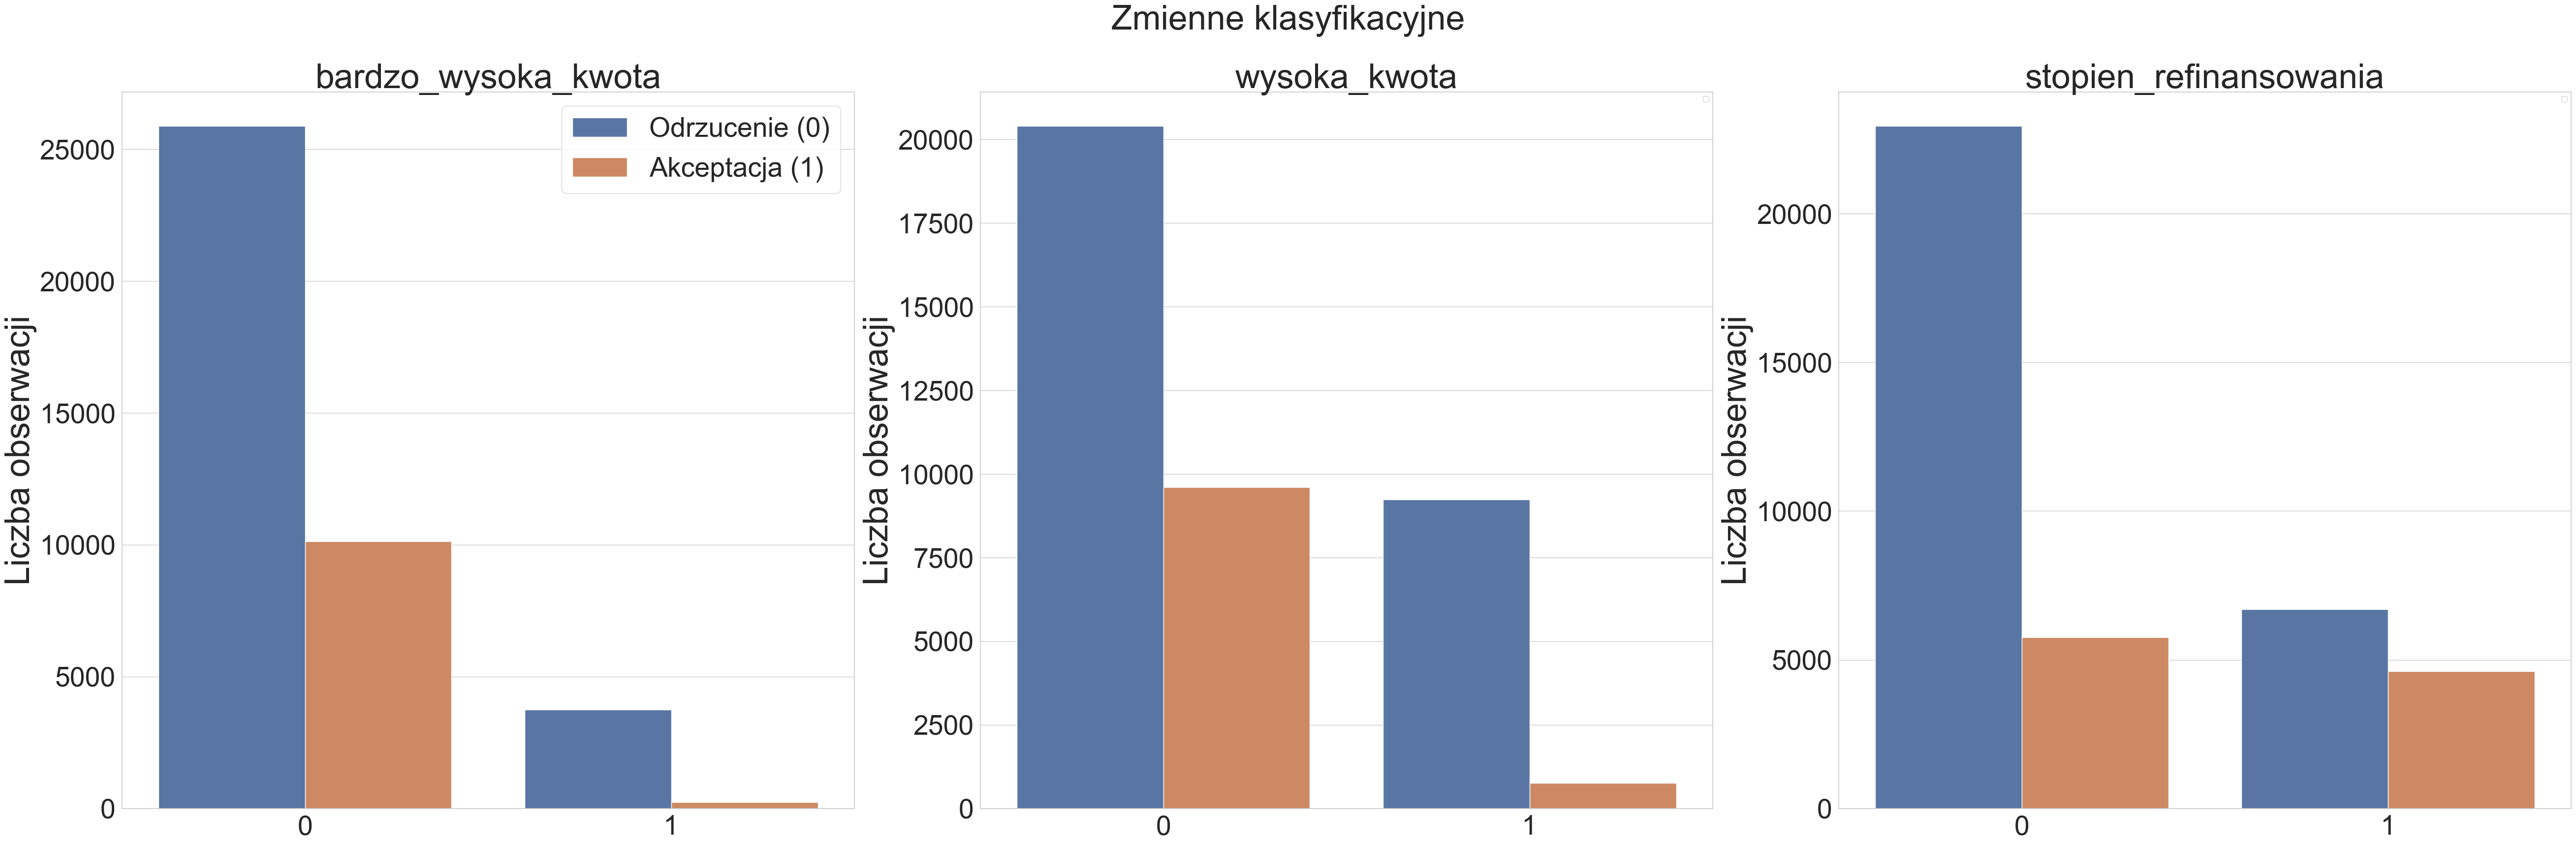

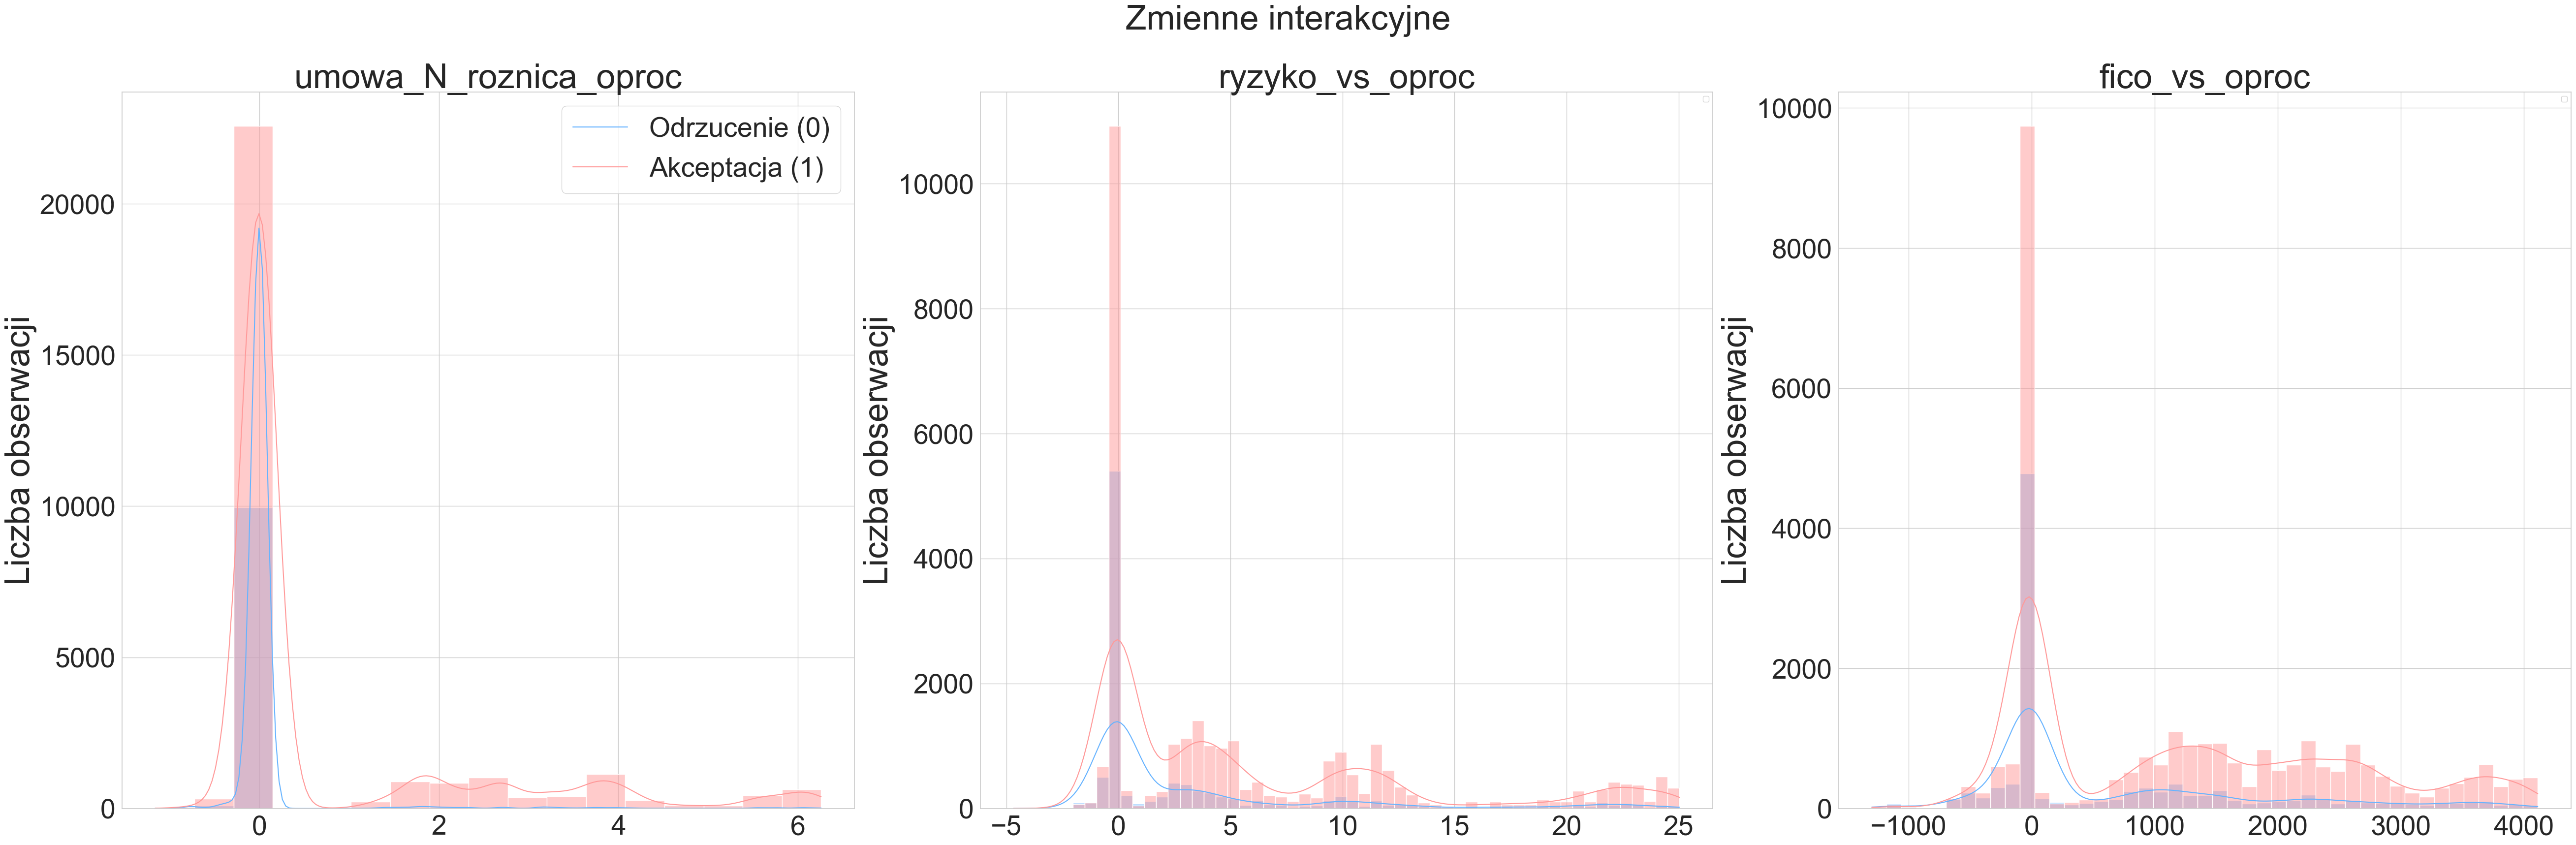

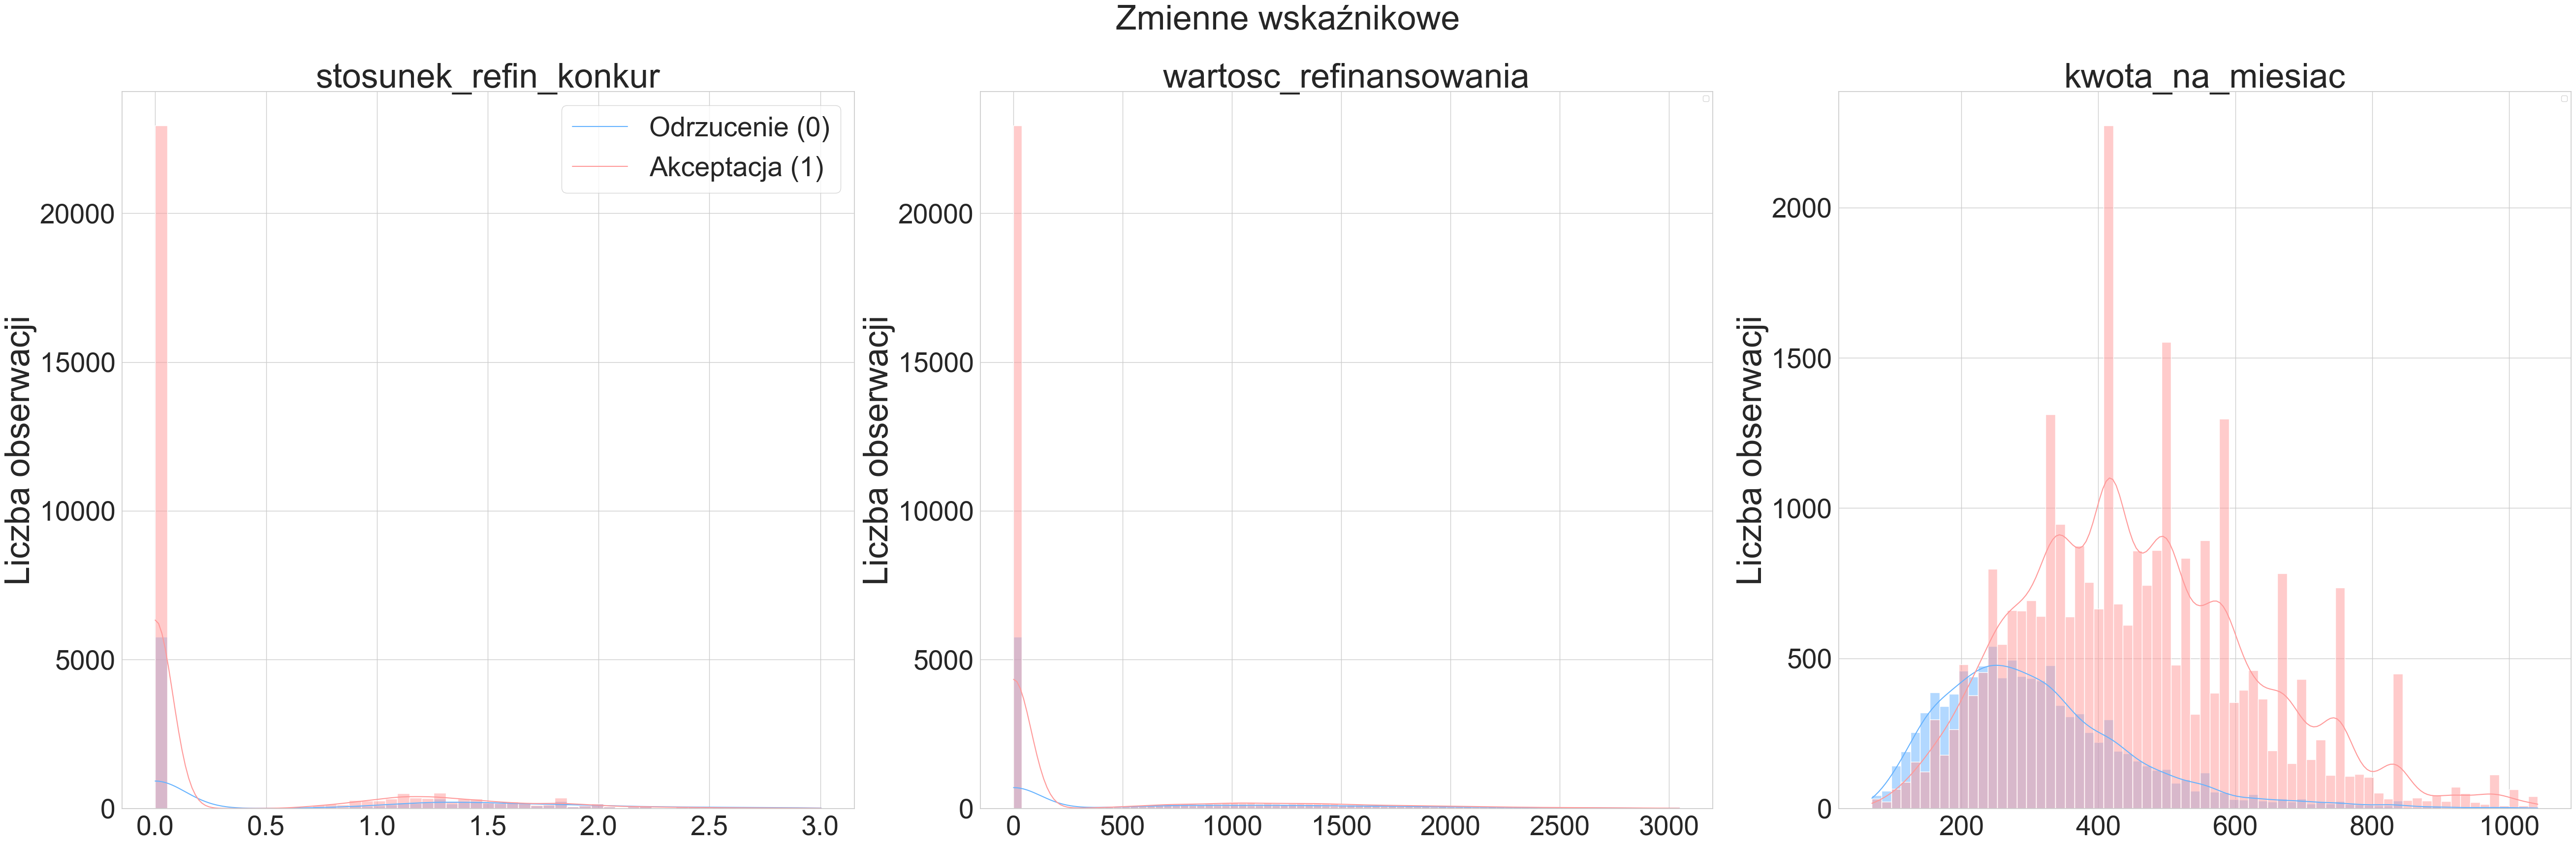

In [20]:
# Ustawienie stylu
sns.set(style="whitegrid")

# Definiowanie grup zmiennych
groups = {
    "Zmienne różnicowe": ["roznica_oproc", "roznica_kosztu"],
    "Zmienne klasyfikacyjne": ["bardzo_wysoka_kwota", "wysoka_kwota", "stopien_refinansowania"],
    "Zmienne interakcyjne": ["umowa_N_roznica_oproc", "ryzyko_vs_oproc", "fico_vs_oproc"],
    "Zmienne wskaźnikowe": ["stosunek_refin_konkur", "wartosc_refinansowania", "kwota_na_miesiac"]
}

# Tworzenie histogramów dla każdej grupy zmiennych
for group_name, variables in groups.items():
    # Określenie liczby wierszy i kolumn
    n_vars = len(variables)
    n_cols = min(3, n_vars)
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    # Utworzenie wykresu - zwiększenie rozmiaru o 350%
    base_width, base_height = 15, 5 * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(base_width * 3.5, base_height * 3.5))
    if n_rows * n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Tworzenie histogramów dla każdej zmiennej
    for i, var in enumerate(variables):
        # Usunięcie wartości odstających dla lepszej wizualizacji
        if project_data[var].dtype in [np.float64, np.int64]:
            upper_limit = np.percentile(project_data[var].dropna(), 99)
            data_to_plot = project_data[project_data[var] <= upper_limit]
        else:
            data_to_plot = project_data
        
        # Sprawdzenie czy zmienna jest binarna (0/1)
        if set(data_to_plot[var].unique()).issubset({0, 1}):
            # Dla zmiennych binarnych tworzymy wykres słupkowy
            sns.countplot(x=var, hue="akceptacja_klienta", data=data_to_plot, ax=axes[i])
        else:
            # Dla zmiennych ciągłych tworzymy histogram z podziałem na akceptację
            sns.histplot(data=data_to_plot, x=var, hue="akceptacja_klienta", 
                        kde=True, ax=axes[i], palette=["#ff9999", "#66b3ff"])
        
        # Zwiększenie rozmiaru czcionki w tytułach i etykietach
        axes[i].set_title(var, fontsize=50)
        axes[i].set_xlabel("", fontsize=50)
        axes[i].set_ylabel("Liczba obserwacji", fontsize=50)
        axes[i].tick_params(labelsize=40)
        
        # Dodanie legendy tylko raz
        if i == 0:
            axes[i].legend(["Odrzucenie (0)", "Akceptacja (1)"], fontsize=40)
        else:
            axes[i].legend([])
    
    # Ukrycie pustych wykresów
    for i in range(len(variables), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'{group_name}', fontsize=50)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [ ]:
print(project_data)

          LP data_akceptacji  grupa_ryzyka  kod_partnera typ_umowy  \
0          1       17/4/2005             2             2         R   
1          2       17/4/2005             2             2         N   
2          3       17/4/2005             1             3         N   
3          4       17/4/2005             1             1         R   
4          5       17/4/2005             3             1         U   
...      ...             ...           ...           ...       ...   
39995  39996       4/10/2005             3             1         U   
39996  39997       4/10/2005             3             1         N   
39997  39998       5/10/2005             1             1         N   
39998  39999       4/10/2005             3             3         U   
39999  40000       5/10/2005             4             2         R   

       scoring_FICO  okres_kredytu kwota_kredytu oproc_refin oproc_konkur  \
0               702             48       $26,500       3.99%        4.99%   
1    